In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast

In [3]:
import torch
from torch_geometric.data import Data, DataLoader

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI
from tdc.multi_pred import DrugSyn
# data = DrugSyn(name = 'OncoPolyPharmacology')



In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [11]:
fdtype = torch.float32

In [12]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### MatchMaker DrugComb Dataset (v1.4 based)

In [13]:
data = pd.read_csv('../data/drugcomb/matchmaker/DrugCombinationData.tsv', sep='\t')
data

,drug_row,drug_col,cell_line_name,synergy_loewe
0,(+)-BICUCULLINE,TEMOZOLOMIDE,T98G,4.436431
1,(+)-JQ1,(+)-JQ1,RD,1.283298
2,(+)-JQ1,717906-29-1,A-673,-17.246800
3,(+)-JQ1,MK-2206,RD,0.847213
4,(+)-JQ1,RUXOLITINIB,L-1236,-30.821293
...,...,...,...,...
286416,warfarin,RUXOLITINIB,L-1236,-18.922317
286417,xylometazoline,717906-29-1,A-673,-6.770255
286418,xylometazoline,RUXOLITINIB,L-1236,-1.628230
286419,yc-1,717906-29-1,A-673,-4.509199


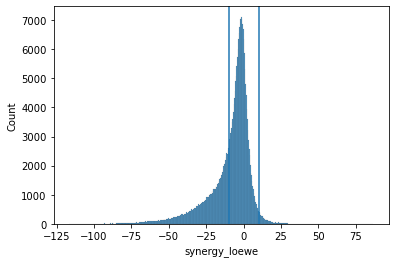

In [24]:
sns.histplot(data.synergy_loewe)
plt.axvline(10, 0,1.0)
plt.axvline(-10, 0,1.0)


In [15]:
from scipy import stats

lz = stats.zscore(data.synergy_loewe)


<AxesSubplot:xlabel='synergy_loewe', ylabel='Count'>

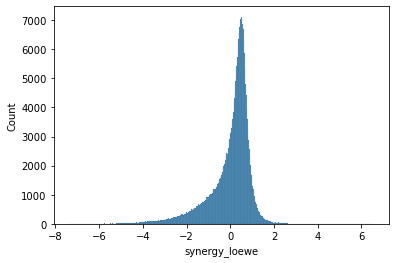

In [16]:
sns.histplot(lz)

In [15]:
len(data[data.synergy_loewe >= 10.0]) # positive samples (value 1)

5698

In [17]:
# data[data.synergy_loewe >= 10.0].tail(100)

In [17]:
len(data[data.synergy_loewe <= -10.0]) # negative samples (value 0)

90973

In [18]:
data_drugnameset = set(list(data['drug_row']) + list(data['drug_col']))
len(data_drugnameset)

3040

In [19]:
# pd.Series(sorted(list(data_drugnameset))).to_csv('../data/drugcomb/matchmaker/unique_drug_names.tsv', sep='\t', index=False)

In [20]:
loewe_bins = np.digitize(data.synergy_loewe, [data.synergy_loewe.min(), -10, 10])

In [21]:
np.unique(loewe_bins, return_counts=True)

(array([1, 2, 3]), array([ 90973, 189750,   5698]))

In [22]:
loewe_binarized = np.vectorize({1:0, 2:-1, 3:1}.get)(loewe_bins)

In [23]:
data["loewe_bin"] = loewe_binarized
data

,drug_row,drug_col,cell_line_name,synergy_loewe,loewe_bin
0,(+)-BICUCULLINE,TEMOZOLOMIDE,T98G,4.436431,-1
1,(+)-JQ1,(+)-JQ1,RD,1.283298,-1
2,(+)-JQ1,717906-29-1,A-673,-17.246800,0
3,(+)-JQ1,MK-2206,RD,0.847213,-1
4,(+)-JQ1,RUXOLITINIB,L-1236,-30.821293,0
...,...,...,...,...,...
286416,warfarin,RUXOLITINIB,L-1236,-18.922317,0
286417,xylometazoline,717906-29-1,A-673,-6.770255,-1
286418,xylometazoline,RUXOLITINIB,L-1236,-1.628230,-1
286419,yc-1,717906-29-1,A-673,-4.509199,-1


### Replace Chemical, Cell values

In [24]:
df_cell_line_gex = pd.read_csv('../data/drugcomb/matchmaker/data/cell_line_gex.csv', sep=',', header=None)
df_cell_line_gex

,0,1,2,3,4,5,6,7,8,9,...,962,963,964,965,966,967,968,969,970,971
0,5.663851,3.989883,7.225384,5.817089,4.745774,2.964538,5.018993,7.277505,4.668266,6.602987,...,7.352872,3.484291,10.303567,6.401597,3.248567,8.001268,12.671700,5.176110,7.302028,6.192469
1,7.989481,4.007707,5.987979,5.701799,4.627334,3.003211,5.358768,6.948493,5.305473,7.527684,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
2,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
3,7.989481,4.007707,5.987979,5.701799,4.627334,3.003211,5.358768,6.948493,5.305473,7.527684,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
4,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286416,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286417,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
286418,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286419,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601


In [25]:
df_cell_line_gex.columns = ["gex" + str(c) for c in df_cell_line_gex.columns]
df_cell_line_gex

,gex0,gex1,gex2,gex3,gex4,gex5,gex6,gex7,gex8,gex9,...,gex962,gex963,gex964,gex965,gex966,gex967,gex968,gex969,gex970,gex971
0,5.663851,3.989883,7.225384,5.817089,4.745774,2.964538,5.018993,7.277505,4.668266,6.602987,...,7.352872,3.484291,10.303567,6.401597,3.248567,8.001268,12.671700,5.176110,7.302028,6.192469
1,7.989481,4.007707,5.987979,5.701799,4.627334,3.003211,5.358768,6.948493,5.305473,7.527684,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
2,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
3,7.989481,4.007707,5.987979,5.701799,4.627334,3.003211,5.358768,6.948493,5.305473,7.527684,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
4,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286416,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286417,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
286418,3.329406,5.683341,6.836749,6.870374,6.276211,3.216432,8.557395,7.099739,6.022584,5.226608,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286419,7.301344,4.125088,7.127670,6.293952,4.791631,2.869414,5.414478,7.848292,5.310444,5.357748,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601


In [26]:
data_gex = pd.concat([data, df_cell_line_gex], axis=1)
data_gex

,drug_row,drug_col,cell_line_name,synergy_loewe,loewe_bin,gex0,gex1,gex2,gex3,gex4,...,gex962,gex963,gex964,gex965,gex966,gex967,gex968,gex969,gex970,gex971
0,(+)-BICUCULLINE,TEMOZOLOMIDE,T98G,4.436431,-1,5.663851,3.989883,7.225384,5.817089,4.745774,...,7.352872,3.484291,10.303567,6.401597,3.248567,8.001268,12.671700,5.176110,7.302028,6.192469
1,(+)-JQ1,(+)-JQ1,RD,1.283298,-1,7.989481,4.007707,5.987979,5.701799,4.627334,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
2,(+)-JQ1,717906-29-1,A-673,-17.246800,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
3,(+)-JQ1,MK-2206,RD,0.847213,-1,7.989481,4.007707,5.987979,5.701799,4.627334,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
4,(+)-JQ1,RUXOLITINIB,L-1236,-30.821293,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286416,warfarin,RUXOLITINIB,L-1236,-18.922317,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286417,xylometazoline,717906-29-1,A-673,-6.770255,-1,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
286418,xylometazoline,RUXOLITINIB,L-1236,-1.628230,-1,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
286419,yc-1,717906-29-1,A-673,-4.509199,-1,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601


In [40]:
MM_vc = data_gex.cell_line_name.value_counts()#.head(10)
MM_vc

SW-620     5511
NCIH23     5495
SK-OV-3    5494
HT29       5478
UACC62     5453
           ... 
RKO         451
RD           90
L-428        48
HDLM-2       48
TC-71        44
Name: cell_line_name, Length: 81, dtype: int64

In [42]:
MM_CellLines = data_gex[["cell_line_name"] + ["gex"+str(i) for i in range(972)]].drop_duplicates().set_index("cell_line_name")#.to_csv('../data/synergxdb/RMA/MM_CellLines.tsv', sep='\t')
MM_CellLines = MM_CellLines.loc[MM_vc.index]
MM_CellLines

,gex0,gex1,gex2,gex3,gex4,gex5,gex6,gex7,gex8,gex9,...,gex962,gex963,gex964,gex965,gex966,gex967,gex968,gex969,gex970,gex971
SW-620,7.822307,3.993789,6.109785,5.392926,4.806857,3.059975,4.837564,8.279649,6.153583,6.714320,...,8.508768,3.957028,7.588000,6.708913,3.641272,7.724635,12.056436,3.731159,6.901609,7.759820
NCIH23,7.319616,3.734341,5.117732,5.671217,4.940168,2.930141,4.825782,9.654326,5.471053,6.762515,...,7.343168,4.237380,8.018189,5.607217,2.908514,8.750274,12.344561,3.803513,4.688126,7.458136
SK-OV-3,7.284218,3.787772,6.502160,5.107719,5.239360,3.122799,5.532191,6.359510,5.348629,5.711413,...,7.237367,3.431658,10.697683,6.982204,3.267673,8.670192,12.289267,4.861253,7.177244,5.487370
HT29,7.356123,4.826544,6.831213,6.496764,5.078656,3.228756,5.597560,7.551820,4.912582,7.649984,...,6.950722,4.093481,8.151445,7.158964,3.542972,8.785220,12.343097,3.198378,3.682483,5.807202
UACC62,7.474971,4.171991,6.218747,6.447016,4.720889,3.146985,4.923914,7.483798,5.238264,7.940613,...,7.036469,4.287018,8.424392,6.177688,3.382619,8.736610,12.728973,5.681155,5.110408,6.075460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RKO,7.043944,3.682798,6.653462,6.503737,4.832114,3.019910,4.707909,8.407891,5.408390,6.662050,...,8.693624,4.739736,7.637634,7.968925,2.985260,9.115454,12.176803,2.713641,7.863083,5.991539
RD,7.989481,4.007707,5.987979,5.701799,4.627334,3.003211,5.358768,6.948493,5.305473,7.527684,...,7.008577,3.651012,9.396186,6.075690,3.426226,8.538285,12.413770,3.630694,3.173746,5.870894
L-428,3.179177,3.867113,6.732431,7.474453,8.031358,3.142553,8.035279,7.996261,5.985003,7.250687,...,6.972535,3.362318,3.295793,6.308069,3.568826,7.922298,11.755719,3.146011,7.623645,6.901444
HDLM-2,3.096158,5.233871,7.407980,7.674308,7.035024,2.936381,7.923381,8.196644,5.910927,5.393349,...,7.335309,4.792545,3.221625,8.142774,3.438623,9.210589,12.356650,4.264449,8.990027,5.623239


In [48]:
pd.concat([MM_CellLines, data_gex.cell_line_name.value_counts()], axis=1).reset_index().rename(columns={"index":"name", "cell_line_name":"count"}).to_csv('../data/synergxdb/RMA/MM_CellLines.tsv', sep='\t', index=False)

In [ ]:
# pd.read_csv('../data/drugcomb/matchmaker/data/drug1_chem.csv', sep=',').shape

In [208]:
# pd.read_csv('../data/drugcomb/matchmaker/data/drug2_chem.csv', sep=',').head()

In [209]:
data_sel = data_gex[data_gex['loewe_bin'] >= 0].copy()
data_sel.index = range(len(data_sel))
data_sel

,drug_row,drug_col,cell_line_name,synergy_loewe,loewe_bin,gex0,gex1,gex2,gex3,gex4,...,gex962,gex963,gex964,gex965,gex966,gex967,gex968,gex969,gex970,gex971
0,(+)-JQ1,717906-29-1,A-673,-17.246800,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
1,(+)-JQ1,RUXOLITINIB,L-1236,-30.821293,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
2,(+)-JQ1,TEMOZOLOMIDE,T98G,30.958026,1,5.663851,3.989883,7.225384,5.817089,4.745774,...,7.352872,3.484291,10.303567,6.401597,3.248567,8.001268,12.671700,5.176110,7.302028,6.192469
3,(-)-BLEBBISTATIN,717906-29-1,A-673,-16.097351,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
4,(-)-BLEBBISTATIN,RUXOLITINIB,L-1236,-18.680123,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96666,tm30089,717906-29-1,A-673,-10.239866,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,6.226398,4.003244,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601
96667,tm30089,RUXOLITINIB,L-1236,-29.196900,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
96668,trans-Piceatannol,RUXOLITINIB,L-1236,-29.407219,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125
96669,valacyclovir,RUXOLITINIB,L-1236,-23.016927,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,6.684069,4.521489,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125


In [210]:
data_sel['loewe_bin'].value_counts()

0    90973
1     5698
Name: loewe_bin, dtype: int64

In [211]:
df_pubchem_smiles = pd.read_csv('../data/drugcomb/matchmaker/pubchem.csv', sep=',')
df_pubchem_smiles

,DrugName,CID,CanonicalSmiles
0,(+)-BICUCULLINE,10237,CN1CCC2=CC3=C(C=C2C1C4C5=C(C6=C(C=C5)OCO6)C(=O...
1,(+)-JQ1,46907787,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...
2,(+)-MATRINE,86573029,C1CC2C3CCCN4C3C(CCC4)CN2C(=O)C1
3,(+)-USNIACIN,24211,CC1=C(C(=C2C(=C1O)C3(C(=CC(=C(C3=O)C(=O)C)O)O2...
4,(-)-BLEBBISTATIN,5287792,CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O
...,...,...,...
3035,valacyclovir,135398742,CC(C)C(C(=O)OCCOCN1C=NC2=C1N=C(NC2=O)N)N
3036,vindesine sulfate,71312023,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...
3037,warfarin,54678486,CC(=O)CC(C1=CC=CC=C1)C2=C(C3=CC=CC=C3OC2=O)O
3038,xylometazoline,5709,CC1=CC(=CC(=C1CC2=NCCN2)C)C(C)(C)C


In [212]:
dict_pubchem_smiles = dict(zip(df_pubchem_smiles.DrugName, df_pubchem_smiles.CanonicalSmiles))
dict_pubchem_smiles

{'(+)-BICUCULLINE': 'CN1CCC2=CC3=C(C=C2C1C4C5=C(C6=C(C=C5)OCO6)C(=O)O4)OCO3',
 '(+)-JQ1': 'CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)C)C4=CC=C(C=C4)Cl)C',
 '(+)-MATRINE': 'C1CC2C3CCCN4C3C(CCC4)CN2C(=O)C1',
 '(+)-USNIACIN': 'CC1=C(C(=C2C(=C1O)C3(C(=CC(=C(C3=O)C(=O)C)O)O2)C)C(=O)C)O',
 '(-)-BLEBBISTATIN': 'CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O',
 '(-)-EPIGALLOCATECHIN GALLATE': 'C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C(=C3)O)O)O)OC(=O)C4=CC(=C(C(=C4)O)O)O',
 '(-)-HUPERZINE A (HUPA)': 'CC=C1C2CC3=C(C1(CC(=C2)C)N)C=CC(=O)N3',
 '(-)-Indolactam V': 'CC(C)C1C(=O)NC(CC2=CNC3=C2C(=CC=C3)N1C)CO',
 '(-)-MK 801 MALEATE': 'CC12C3=CC=CC=C3CC(N1)C4=CC=CC=C24.C(=CC(=O)O)C(=O)O',
 '(-)-PARTHENOLIDE': 'CC1=CCCC2(C(O2)C3C(CC1)C(=C)C(=O)O3)C',
 '(-)-chlorpheniramine': 'CN(C)CCC(C1=CC=C(C=C1)Cl)C2=CC=CC=N2',
 '(3S,4R)-Tofacitinib': 'CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N',
 '(Phenylindolyl)maleimide deriv. 79': 'CN1C=C(C2=CC=CC=C21)C3=C(C(=O)NC3=O)C4=CC(=CC(=C4)Cl)Cl',
 '(R)-(-)-Rolipram': 'COC1=

In [213]:
data_sel['Drug1'] = data_sel['drug_row']
data_sel['Drug2'] = data_sel['drug_col']

In [214]:
data_sel = data_sel.rename(columns={"drug_row": "Drug1_ID", "drug_col": "Drug2_ID", "loewe_bin": "Y"})
data_sel.columns

Index(['Drug1_ID', 'Drug2_ID', 'cell_line_name', 'synergy_loewe', 'Y', 'gex0',
       'gex1', 'gex2', 'gex3', 'gex4',
       ...
       'gex964', 'gex965', 'gex966', 'gex967', 'gex968', 'gex969', 'gex970',
       'gex971', 'Drug1', 'Drug2'],
      dtype='object', length=979)

In [215]:
data_sel = data_sel.replace({"Drug1": dict_pubchem_smiles, "Drug2": dict_pubchem_smiles})
data_sel

,Drug1_ID,Drug2_ID,cell_line_name,synergy_loewe,Y,gex0,gex1,gex2,gex3,gex4,...,gex964,gex965,gex966,gex967,gex968,gex969,gex970,gex971,Drug1,Drug2
0,(+)-JQ1,717906-29-1,A-673,-17.246800,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...
1,(+)-JQ1,RUXOLITINIB,L-1236,-30.821293,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...,C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
2,(+)-JQ1,TEMOZOLOMIDE,T98G,30.958026,1,5.663851,3.989883,7.225384,5.817089,4.745774,...,10.303567,6.401597,3.248567,8.001268,12.671700,5.176110,7.302028,6.192469,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...,CN1C(=O)N2C=NC(=C2N=N1)C(=O)N
3,(-)-BLEBBISTATIN,717906-29-1,A-673,-16.097351,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601,CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...
4,(-)-BLEBBISTATIN,RUXOLITINIB,L-1236,-18.680123,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125,CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O,C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96666,tm30089,717906-29-1,A-673,-10.239866,0,7.301344,4.125088,7.127670,6.293952,4.791631,...,4.800379,4.054451,3.141192,8.905584,12.404574,4.436077,6.337026,6.689601,CN(C1CCC2=C(C1)C3=CC=CC=C3N2CC(=O)O)S(=O)(=O)C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...
96667,tm30089,RUXOLITINIB,L-1236,-29.196900,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125,CN(C1CCC2=C(C1)C3=CC=CC=C3N2CC(=O)O)S(=O)(=O)C...,C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
96668,trans-Piceatannol,RUXOLITINIB,L-1236,-29.407219,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125,C1=CC(=C(C=C1C=CC2=CC(=CC(=C2)O)O)O)O,C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3
96669,valacyclovir,RUXOLITINIB,L-1236,-23.016927,0,3.329406,5.683341,6.836749,6.870374,6.276211,...,3.064505,6.147169,3.375235,9.863542,11.162546,3.527803,6.952629,7.190125,CC(C)C(C(=O)OCCOCN1C=NC2=C1N=C(NC2=O)N)N,C1CCC(C1)C(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3


### Preparing dataset 

In [216]:
# TDC Tox
DSdataset_name = 'MatchMakerDrugComb' #'DrugComb'
# OncoPolyPharmacology is the MERCK dataset


#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [217]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [218]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/MatchMakerDrugComb/data_v1'

In [219]:
set(list(data_sel.Drug1_ID) + list(data_sel.Drug2_ID))

{'SPARFLOXACIN',
 'PIROXICAM',
 'ROLIPRAM',
 'GSK 525768A',
 'MANIDIPINE',
 'ALIZARIN',
 'TANDUTINIB (MLN518)',
 'norepinephrine',
 'C188-9',
 'phenoxybenzamine',
 'VISMODEGIB',
 'SCHEMBL13210325',
 'FOSAPREPITANT DIMEGLUMINE SALT',
 'GSK J4 HCL',
 'Cidofovir',
 'CILENGITIDE',
 'RISPERIDONE',
 'shikonin',
 'FISETIN',
 'DAPT (GSI-IX)',
 'NAPROXEN',
 'ITMN191',
 'CHEMBL3348995',
 'CHEMBL3348949',
 'MORIN HYDRATE',
 'TARIQUIDAR',
 'orphenadrine',
 'BETAMETHASONE DIPROPIONATE',
 'Solaraze',
 'Cefprozil monohydrate',
 'Monatepil',
 'UNC0638',
 'VITAMIN C',
 'ondansetron',
 'NCGC00345810-01',
 'acetaminophen',
 'AVASIMIBE',
 'FMAU',
 'CHEMBL3348822',
 'NCGC00016641-01',
 'BUFEXAMAC',
 'BLEOMYCIN',
 'BI-D1870',
 'PERHEXILINE',
 'PURVALANOL B',
 'U0126-ETOH',
 'CHEMBL3348847',
 'DOMIPHEN BROMIDE',
 'CHEMBL3856067',
 'Lipase Inhibitor, THL',
 'NCGC00178127-04',
 'H 89 2HCL',
 '888719-03-7',
 'IC-87114',
 'SGX-523',
 'histamine',
 'Risedronate sodium',
 'PONATINIB (AP24534)',
 'NCGC00183844-01',

In [220]:
# uniq_data = df_pubchem_smiles[df_pubchem_smiles.DrugName.isin(set(list(data_sel.Drug1_ID) + list(data_sel.Drug2_ID)))].drop("CID", axis=1)
# uniq_data.columns = ["Drug_ID", "Drug"]
# uniq_data

In [221]:
uniq_data = ddi_dataframe_to_unique_drugs(data_sel)
uniq_data

,Drug_ID,Drug
0,(+)-JQ1,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...
1,(-)-BLEBBISTATIN,CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O
2,(-)-Indolactam V,CC(C)C1C(=O)NC(CC2=CNC3=C2C(=CC=C3)N1C)CO
3,(-)-MK 801 MALEATE,CC12C3=CC=CC=C3CC(N1)C4=CC=CC=C24.C(=CC(=O)O)C...
4,(-)-chlorpheniramine,CN(C)CCC(C1=CC=C(C=C1)Cl)C2=CC=CC=N2
...,...,...
2009,CUDC-907,CN(CC1=CC2=C(S1)C(=NC(=N2)C3=CN=C(C=C3)OC)N4CC...
2010,Sepantronium,CC1=[N+](C2=C(N1CCOC)C(=O)C3=CC=CC=C3C2=O)CC4=...
2011,actinomycin D,CC1C(C(=O)NC(C(=O)N2CCCC2C(=O)N(CC(=O)N(C(C(=O...
2012,MK-8776,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4


In [222]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

RDKit WARNING: [15:57:15] WARNING: not removing hydrogen atom without neighbors
[15:57:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:57:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:57:15] WARNING: not removing hydrogen atom without neighbors
[15:57:15] WARNING: not removing hydrogen atom without neighbors
[15:57:15] WARNING: not removing hydrogen atom without neighbors


In [223]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

RDKit WARNING: [15:57:15] WARNING: not removing hydrogen atom without neighbors
[15:57:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:57:17] WARNING: not removing hydrogen atom without neighbors
[15:57:17] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:57:17] WARNING: not removing hydrogen atom without neighbors
[15:57:17] WARNING: not removing hydrogen atom without neighbors


,Drug,Mol,DataOGB
Drug_ID,,,
(+)-JQ1,CC1=C(SC2=C1C(=NC(C3=NN=C(N32)C)CC(=O)OC(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x2b775bb05220>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
(-)-BLEBBISTATIN,CC1=CC2=C(C=C1)N=C3C(C2=O)(CCN3C4=CC=CC=C4)O,<rdkit.Chem.rdchem.Mol object at 0x2b775bb05a60>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
(-)-Indolactam V,CC(C)C1C(=O)NC(CC2=CNC3=C2C(=CC=C3)N1C)CO,<rdkit.Chem.rdchem.Mol object at 0x2b775bb058e0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
(-)-MK 801 MALEATE,CC12C3=CC=CC=C3CC(N1)C4=CC=CC=C24.C(=CC(=O)O)C...,<rdkit.Chem.rdchem.Mol object at 0x2b775bb05fa0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
(-)-chlorpheniramine,CN(C)CCC(C1=CC=C(C=C1)Cl)C2=CC=CC=N2,<rdkit.Chem.rdchem.Mol object at 0x2b775bb053a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 1, 3,..."
...,...,...,...
CUDC-907,CN(CC1=CC2=C(S1)C(=NC(=N2)C3=CN=C(C=C3)OC)N4CC...,<rdkit.Chem.rdchem.Mol object at 0x2b775b34a9a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Sepantronium,CC1=[N+](C2=C(N1CCOC)C(=O)C3=CC=CC=C3C2=O)CC4=...,<rdkit.Chem.rdchem.Mol object at 0x2b775b34aa00>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
actinomycin D,CC1C(C(=O)NC(C(=O)N2CCCC2C(=O)N(CC(=O)N(C(C(=O...,<rdkit.Chem.rdchem.Mol object at 0x2b775b34aa60>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


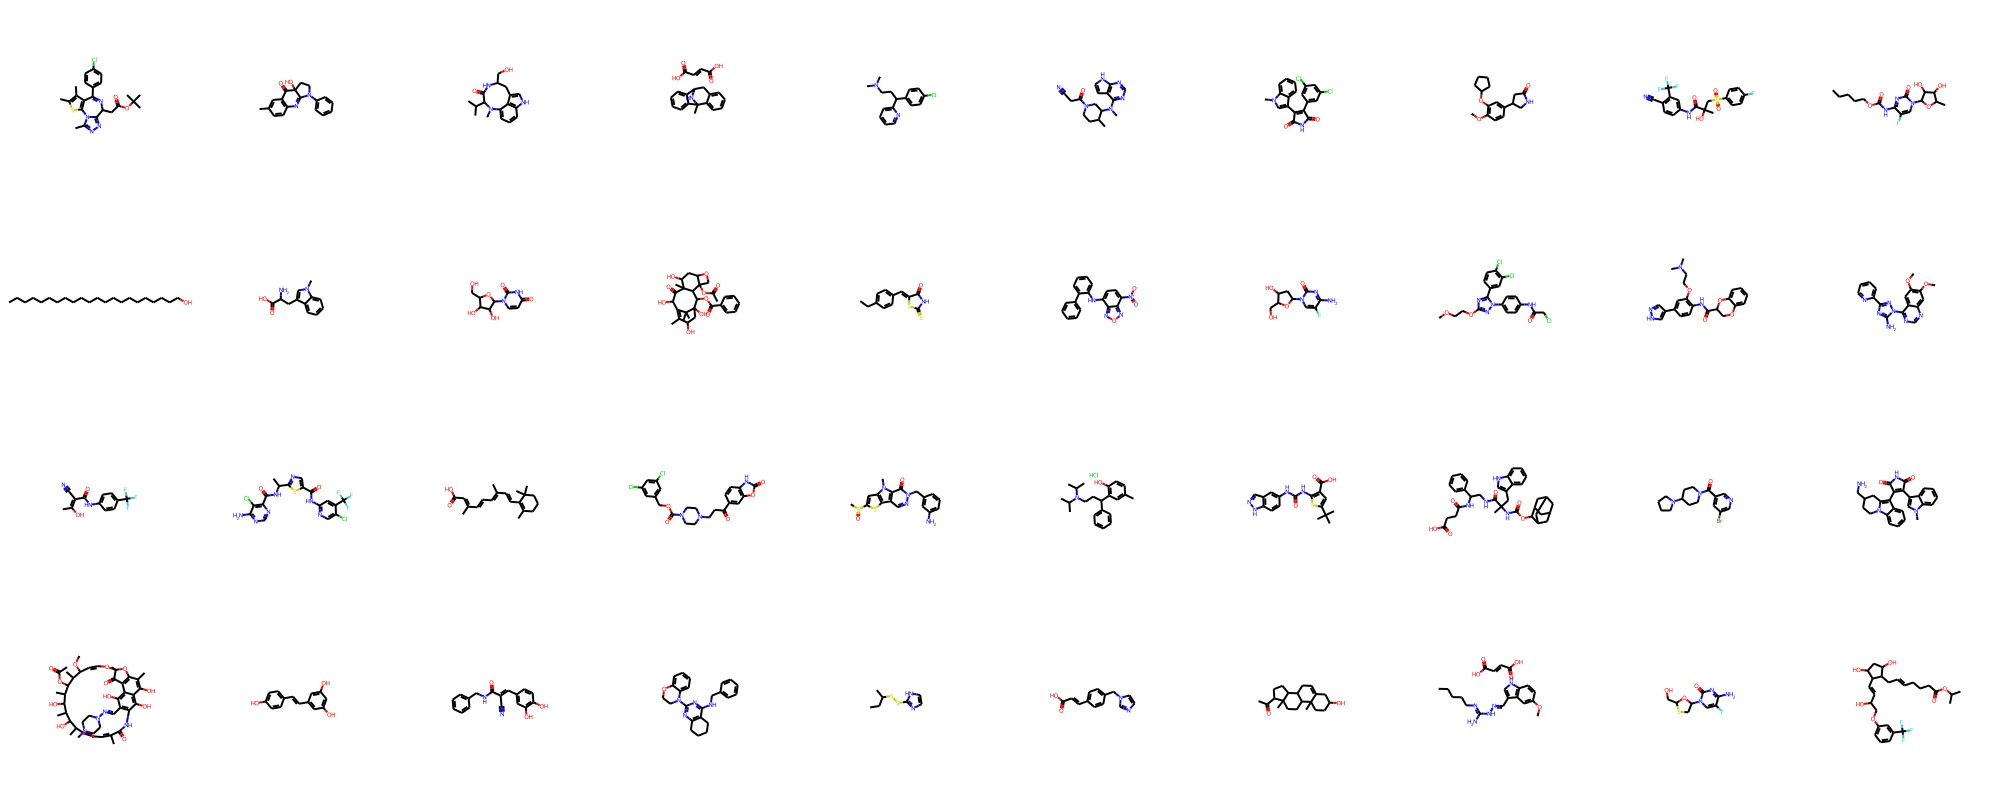

In [224]:
Draw.MolsToGridImage(uniq_mol.Mol.head(40), molsPerRow=10)

In [225]:
# num_drugs = len(uniq_mol)
# int((num_drugs * (num_drugs-1))/2)

In [226]:
# uniq_mol.iloc[0].Data

In [227]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 68], edge_attr=[68, 3], x=[31, 9])

In [228]:
# zhang_labels = pd.read_csv(rawdata_dir + '/DS1/drug_drug_matrix_wids.csv').set_index('Unnamed: 0')
# y_df = zhang_labels

In [229]:
# %%time

# y_df = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'y_df.pkl'),
#                                      data_gen_fun = generate_labels_df,
#                                      data_gen_params=(uniq_mol, datashort))

In [230]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

#y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [231]:
# y_df

In [232]:
# y_df[y_df > 0] = 1
# y_df

In [233]:
# y = get_y_from_interactionmat(y_df.to_numpy())
# len(y)

In [234]:
# binary_Y_threshold = 30

In [235]:
y = data_sel.Y.copy()
y

0        0
1        0
2        1
3        0
4        0
        ..
96666    0
96667    0
96668    0
96669    0
96670    0
Name: Y, Length: 96671, dtype: int64

In [236]:
# str(round((len(y[y>=binary_Y_threshold]) / len(y) *100), 2)) + "% positive labels"

In [237]:
# sns.boxplot(y)

In [238]:
# positive_labels = y>=binary_Y_threshold
# negative_labels = y<binary_Y_threshold

In [239]:
# y[positive_labels] = 1
# y[negative_labels] = 0
# y = y.astype(int)
# y

In [240]:
y.values

array([0, 0, 1, ..., 0, 0, 0])

In [241]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [242]:
y_weights = compute_class_weights(torch.tensor(y.values))
y_weights

array([0.53131698, 8.48288873])

In [243]:
ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [244]:
expression = data_sel.loc[:, 'gex0':'gex971'].values
expression

array([[7.3013444 , 4.12508775, 7.12767043, ..., 4.43607703, 6.33702616,
        6.68960145],
       [3.32940572, 5.68334115, 6.83674908, ..., 3.52780293, 6.95262907,
        7.19012492],
       [5.66385109, 3.98988329, 7.22538383, ..., 5.17611046, 7.30202757,
        6.19246891],
       ...,
       [3.32940572, 5.68334115, 6.83674908, ..., 3.52780293, 6.95262907,
        7.19012492],
       [3.32940572, 5.68334115, 6.83674908, ..., 3.52780293, 6.95262907,
        7.19012492],
       [3.32940572, 5.68334115, 6.83674908, ..., 3.52780293, 6.95262907,
        7.19012492]])

In [245]:
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [246]:
# report_label_distrib(y)

In [247]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)# # pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
# pairs = construct_sampleid_ddipairs(y_df.to_numpy())
# len(pairs)

In [248]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data_sel.iterrows()}
len(pairs)

96671

In [264]:
pairs

{0: ('(+)-JQ1', '717906-29-1'),
 1: ('(+)-JQ1', 'RUXOLITINIB'),
 2: ('(+)-JQ1', 'TEMOZOLOMIDE'),
 3: ('(-)-BLEBBISTATIN', '717906-29-1'),
 4: ('(-)-BLEBBISTATIN', 'RUXOLITINIB'),
 5: ('(-)-Indolactam V', 'RUXOLITINIB'),
 6: ('(-)-MK 801 MALEATE', 'TEMOZOLOMIDE'),
 7: ('(-)-chlorpheniramine', 'RUXOLITINIB'),
 8: ('(3S,4R)-Tofacitinib', 'RUXOLITINIB'),
 9: ('(Phenylindolyl)maleimide deriv. 79', '717906-29-1'),
 10: ('(Phenylindolyl)maleimide deriv. 79', 'RUXOLITINIB'),
 11: ('(R)-(-)-Rolipram', 'RUXOLITINIB'),
 12: ('(R)-Bicalutamide', '717906-29-1'),
 13: ('(R)-Bicalutamide', 'RUXOLITINIB'),
 14: ('1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE',
  'ADM HYDROCHLORIDE'),
 15: ('1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE',
  'ADM HYDROCHLORIDE'),
 16: ('1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(PENTYLOXY)CARBONYL]AMINO}PYRIMIDIN-2(1H)-ONE',
  'ADM HYDROCHLORIDE'),
 17: ('1-(5-DEOXYPENTOFURANOSYL)-5-FLUORO-4-{[(P

In [250]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [251]:
%%time

X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

CPU times: user 16.3 s, sys: 162 ms, total: 16.5 s
Wall time: 16.5 s


In [252]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

#X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [253]:
# X

In [254]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/MatchMakerDrugComb/data_v1'

In [255]:
targetdata_dir_processed

'/cluster/home/skyriakos/chemprop_run/git/data/processed/MatchMakerDrugComb/data_v1/processed'

In [256]:
# import glob

# list_generated_files = glob.glob(targetdata_dir_processed + "/*")
# print(list_generated_files)

# for file in list_generated_files:
#     os.remove(file)

In [257]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...
Done!


CPU times: user 12.5 s, sys: 2.27 s, total: 14.7 s
Wall time: 15.3 s


In [258]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(96671):
Number of graphs: 96671
Number of features: 9
Number of classes: 2


In [259]:
data0

PairData(edge_index_a=[2, 68], x_a=[31, 9], edge_attr_a=[68, 3], edge_index_b=[2, 76], x_b=[35, 9], edge_attr_b=[76, 3], id=[1], y=[1], expression=[1, 972])

In [260]:
data0.expression.dtype

torch.float32

In [261]:
len(dataset)

96671

In [265]:
dataset[0].expression

tensor([[ 7.3013,  4.1251,  7.1277,  6.2940,  4.7916,  2.8694,  5.4145,  7.8483,
          5.3104,  5.3577,  5.7494,  6.1665,  8.2114,  6.7576,  4.7309,  3.3597,
          7.2697,  7.4924,  8.2767,  7.6680,  7.1716,  4.8200,  9.4651,  3.6201,
          4.8028,  7.2292,  5.9073,  2.6948,  6.0576,  6.7371,  3.5425,  7.6675,
          4.8620,  7.9856,  3.3837,  5.0106,  8.1961,  5.1094,  7.3737,  6.5084,
          7.9068,  7.5095,  8.5723,  6.7420,  7.7426,  3.3453,  7.9836,  5.6886,
          7.6885,  3.4478,  3.0822,  7.0361,  3.5099,  4.0510,  2.9558,  8.7376,
          9.1128,  5.6567,  9.1016,  5.3778,  8.7414,  3.3568,  9.2123,  4.1202,
          6.8454,  5.5584,  8.4970,  3.1021,  5.0154,  3.8944,  3.2463,  7.0097,
          4.2405,  5.9265,  7.2564,  5.2703,  3.0498,  3.9002,  7.3297,  6.8502,
          3.8888,  2.8351, 11.1044,  5.8969,  7.9509,  2.9846,  7.7644,  5.1455,
          5.1265,  8.0268,  8.9757,  4.5672,  9.7367,  9.8183,  5.3324,  3.5830,
          7.3243,  6.3825,  

In [263]:
dataset[3].expression

tensor([[ 7.3013,  4.1251,  7.1277,  6.2940,  4.7916,  2.8694,  5.4145,  7.8483,
          5.3104,  5.3577,  5.7494,  6.1665,  8.2114,  6.7576,  4.7309,  3.3597,
          7.2697,  7.4924,  8.2767,  7.6680,  7.1716,  4.8200,  9.4651,  3.6201,
          4.8028,  7.2292,  5.9073,  2.6948,  6.0576,  6.7371,  3.5425,  7.6675,
          4.8620,  7.9856,  3.3837,  5.0106,  8.1961,  5.1094,  7.3737,  6.5084,
          7.9068,  7.5095,  8.5723,  6.7420,  7.7426,  3.3453,  7.9836,  5.6886,
          7.6885,  3.4478,  3.0822,  7.0361,  3.5099,  4.0510,  2.9558,  8.7376,
          9.1128,  5.6567,  9.1016,  5.3778,  8.7414,  3.3568,  9.2123,  4.1202,
          6.8454,  5.5584,  8.4970,  3.1021,  5.0154,  3.8944,  3.2463,  7.0097,
          4.2405,  5.9265,  7.2564,  5.2703,  3.0498,  3.9002,  7.3297,  6.8502,
          3.8888,  2.8351, 11.1044,  5.8969,  7.9509,  2.9846,  7.7644,  5.1455,
          5.1265,  8.0268,  8.9757,  4.5672,  9.7367,  9.8183,  5.3324,  3.5830,
          7.3243,  6.3825,  